In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from datetime import datetime
import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

from collections import deque
from pylab import rcParams


%matplot inline

UsageError: Line magic function `%matplot` not found.


In [54]:
ele_data = pd.read_csv('./process_data/processed_data.csv')
weather_data = pd.read_csv('./process_data/weather.csv')

ele_data = ele_data.iloc[:,:2]
ele_data.columns = ['datetime','zero_t']
print(len(ele_data))
print(ele_data.head())
print(weather_data.head())
dataset_train = pd.merge(ele_data,weather_data,how='inner',on='datetime')
dataset_train.head()

cols = list(dataset_train)[1:8]

# extract dates will be used in visualization
datelist_train = list(dataset_train['datetime'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Traing set shape == {}'.format(dataset_train.shape))
print('all timestamps == {}'.format(len(datelist_train)))
print('featured selecte: {}'.format(cols))
print(dataset_train.info())
dataset_train.head()

1339
     datetime       zero_t
0  2018-01-01  244033.7682
1  2018-01-02  207655.1990
2  2018-01-03  248503.4810
3  2018-01-04  253310.1506
4  2018-01-05  251749.1014
     datetime  high_temp  low_temp  daytime  night  weather1  weather2
0  2018-01-01         22        12       24     24         3         3
1  2018-01-01         22        12       24     24         3         3
2  2018-01-02         22        15       24     24         3         3
3  2018-01-03         23        15       24     24         3        13
4  2018-01-04         21        16       24     24         3         7
Traing set shape == (1345, 8)
all timestamps == 1345
featured selecte: ['zero_t', 'high_temp', 'low_temp', 'daytime', 'night', 'weather1', 'weather2']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345 entries, 0 to 1344
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   datetime   1345 non-null   object 
 1   zero_t     1345 non-null 

,datetime,zero_t,high_temp,low_temp,daytime,night,weather1,weather2
0,2018-01-01,244033.7682,22,12,24,24,3,3
1,2018-01-01,244033.7682,22,12,24,24,3,3
2,2018-01-02,207655.1990,22,15,24,24,3,3
3,2018-01-03,248503.4810,23,15,24,24,3,13
4,2018-01-04,253310.1506,21,16,24,24,3,7


In [55]:
ele_data = pd.read_csv('./process_data/processed_data.csv')
weather_data = pd.read_csv('./process_data/weather.csv')

ele_data = ele_data.iloc[:,:2]
ele_data.columns = ['datetime','zero_t']
print(len(ele_data))
print(ele_data.head())
print(weather_data.head())
dataset_train = pd.merge(ele_data,weather_data,how='inner',on='datetime')
dataset_train.head()

cols = list(dataset_train)[1:8]

# extract dates will be used in visualization
datelist_train = list(dataset_train['datetime'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Traing set shape == {}'.format(dataset_train.shape))
print('all timestamps == {}'.format(len(datelist_train)))
print('featured selecte: {}'.format(cols))
print(dataset_train.info())
dataset_train.head()

1339
     datetime       zero_t
0  2018-01-01  244033.7682
1  2018-01-02  207655.1990
2  2018-01-03  248503.4810
3  2018-01-04  253310.1506
4  2018-01-05  251749.1014
     datetime  high_temp  low_temp  daytime  night  weather1  weather2
0  2018-01-01         22        12       24     24         3         3
1  2018-01-01         22        12       24     24         3         3
2  2018-01-02         22        15       24     24         3         3
3  2018-01-03         23        15       24     24         3        13
4  2018-01-04         21        16       24     24         3         7
Traing set shape == (1345, 8)
all timestamps == 1345
featured selecte: ['zero_t', 'high_temp', 'low_temp', 'daytime', 'night', 'weather1', 'weather2']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345 entries, 0 to 1344
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   datetime   1345 non-null   object 
 1   zero_t     1345 non-null 

,datetime,zero_t,high_temp,low_temp,daytime,night,weather1,weather2
0,2018-01-01,244033.7682,22,12,24,24,3,3
1,2018-01-01,244033.7682,22,12,24,24,3,3
2,2018-01-02,207655.1990,22,15,24,24,3,3
3,2018-01-03,248503.4810,23,15,24,24,3,13
4,2018-01-04,253310.1506,21,16,24,24,3,7


In [56]:
dataset_train.index = dataset_train['datetime']
del dataset_train['datetime']
dataset_train

,zero_t,high_temp,low_temp,daytime,night,weather1,weather2
datetime,,,,,,,
2018-01-01,244033.7682,22,12,24,24,3,3
2018-01-01,244033.7682,22,12,24,24,3,3
2018-01-02,207655.1990,22,15,24,24,3,3
2018-01-03,248503.4810,23,15,24,24,3,13
2018-01-04,253310.1506,21,16,24,24,3,7
...,...,...,...,...,...,...,...
2021-08-27,223670.7666,35,26,12,12,15,15
2021-08-28,223349.5616,33,26,12,12,15,3
2021-08-29,222113.3896,32,25,12,12,15,15


In [57]:
dataset_train.to_csv('zero.csv')

<AxesSubplot:xlabel='datetime'>

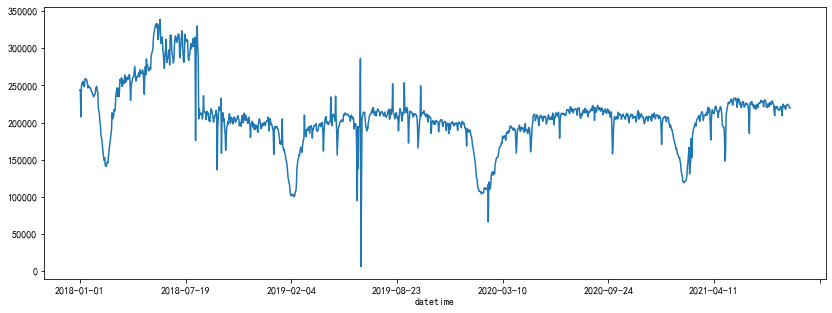

In [58]:
rcParams['figure.figsize'] = 14,5
dataset_train['zero_t'].plot()

In [59]:
n_predict = 10
mem_day = 5
dataset_train['label'] = dataset_train['zero_t'].shift(-n_predict)
print(len(dataset_train))
dataset_train.dropna(inplace=True)  # 前十天没了...，label将第一列数据往下移动10天
print(len(dataset_train))
dataset_train.head()

1345
1335


,zero_t,high_temp,low_temp,daytime,night,weather1,weather2,label
datetime,,,,,,,,
2018-01-01,244033.7682,22,12,24,24,3,3,259171.2066
2018-01-01,244033.7682,22,12,24,24,3,3,257756.5801
2018-01-02,207655.1990,22,15,24,24,3,3,257279.1719
2018-01-03,248503.4810,23,15,24,24,3,13,257543.3267
2018-01-04,253310.1506,21,16,24,24,3,7,254620.2619


In [60]:
df = dataset_train
sc = StandardScaler()
sca_x_train = sc.fit_transform(df.iloc[:,:-1])
sca_x_train.shape

(1335, 7)

In [61]:
def lstm_precessing(dataset_train, mem_day, n_predict):
    scaler = StandardScaler()
    sca_X = scaler.fit_transform(dataset_train.iloc[:,:-1])

    deq  = deque(maxlen=mem_day)

    X = []
    for i in sca_X:
        deq.append(list(i))  # list(i) 7个特征
        if len(deq) == mem_day:  # 滑动窗口大小为mem_day    X.append([[,,,,,,],[],[],..,[][]])
            X.append(list(deq))

    X_lately = X[-n_predict:]
    X = X[:-n_predict]

    y = dataset_train['label'].values[mem_day - 1 : -n_predict] 

    X = np.array(X)
    y = np.array(y)

    return X,y,X_lately

In [62]:
X,y,X_lately = lstm_precessing(dataset_train,mem_day,n_predict)

print('x_train shape == {}'.format(X.shape))
print('y_train shape == {}'.format(y.shape))
print('x_lately shape == {}'.format(len(X_lately)))

x_train shape == (1321, 5, 7)
y_train shape == (1321,)
x_lately shape == 10


In [63]:
pre_days = 10
mem_days = [5]
lstm_layers = [1]
dense_layer = [1]
units = [32]
for the_mem_days in mem_days:
    for the_lstm_layers in lstm_layers:
        for the_dense_layers in dense_layer:
            for the_units in units:
                filepath = './models/{val_mape:.2f}_{epoch:02d}_'+f'men_{the_lstm_layers}_lstm_{the_lstm_layers}_dense_{the_lstm_layers}_unit_{the_units}'
                checkpoint = ModelCheckpoint(filepath=filepath,
                                             save_weights_only = False,
                                             monitor='val_mape',
                                             mode='min',
                                             save_best_only=True)
                # print(filepath)
                X,y,X_lately = lstm_precessing(dataset_train,the_mem_days,pre_days)
                X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False,test_size=0.1)
                model = Sequential()
                # 第一层
                model.add(LSTM(the_units, input_shape=X.shape[1:], activation='relu',return_sequences=True)) # 10个神经元   回归性质return_sequences=True
                model.add(Dropout(0.1)) # 防止过拟合，删除0.1%的神经元

                # 构建第二层
                for i in range(the_lstm_layers):
                    model.add(LSTM(the_units, activation='relu',return_sequences=True))
                    model.add(Dropout(0.1))

                # 第三层
                model.add(LSTM(the_units, activation='relu'))
                model.add(Dropout(0.1))

                # 输出层
                for i in range(the_dense_layers):
                    model.add(Dense(the_units,activation='relu'))
                    model.add(Dropout(0.1))

                model.add(Dense(1))
                # 编译
                model.compile(optimizer='adam', loss='mse', metrics=['mape'])

                model.fit(X_train, y_train,batch_size=32,epochs=50, validation_data=(X_test,y_test),callbacks=checkpoint)

Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 44380725248.0000 - mape: 99.9998INFO:tensorflow:Assets written to: ./models\100.00_01_men_1_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\100.00_01_men_1_lstm_1_dense_1_unit_32\assets


38/38 [==============================] - 27s 326ms/step - loss: 44380725248.0000 - mape: 99.9998 - val_loss: 48856195072.0000 - val_mape: 99.9992
Epoch 2/50
37/38 [============================>.] - ETA: 0s - loss: 43999395840.0000 - mape: 99.6663INFO:tensorflow:Assets written to: ./models\98.97_02_men_1_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\98.97_02_men_1_lstm_1_dense_1_unit_32\assets


38/38 [==============================] - 9s 246ms/step - loss: 44031606784.0000 - mape: 99.6591 - val_loss: 47841996800.0000 - val_mape: 98.9715
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 23576920064.0000 - mape: 70.6797INFO:tensorflow:Assets written to: ./models\81.26_03_men_1_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\81.26_03_men_1_lstm_1_dense_1_unit_32\assets


38/38 [==============================] - 10s 259ms/step - loss: 23576920064.0000 - mape: 70.6797 - val_loss: 32738246656.0000 - val_mape: 81.2613
Epoch 4/50
36/38 [===========================>..] - ETA: 0s - loss: 8289566720.0000 - mape: 38.7321INFO:tensorflow:Assets written to: ./models\53.46_04_men_1_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\53.46_04_men_1_lstm_1_dense_1_unit_32\assets


38/38 [==============================] - 9s 238ms/step - loss: 8199498752.0000 - mape: 38.6420 - val_loss: 14685378560.0000 - val_mape: 53.4647
Epoch 5/50
35/38 [==========================>...] - ETA: 0s - loss: 4256604416.0000 - mape: 29.0314INFO:tensorflow:Assets written to: ./models\22.48_05_men_1_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\22.48_05_men_1_lstm_1_dense_1_unit_32\assets


38/38 [==============================] - 9s 248ms/step - loss: 4198800128.0000 - mape: 28.7739 - val_loss: 3307186944.0000 - val_mape: 22.4849
Epoch 6/50
34/38 [=========================>....] - ETA: 0s - loss: 3144248320.0000 - mape: 24.7070INFO:tensorflow:Assets written to: ./models\21.84_06_men_1_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\21.84_06_men_1_lstm_1_dense_1_unit_32\assets


38/38 [==============================] - 9s 230ms/step - loss: 3154564352.0000 - mape: 24.6810 - val_loss: 3026287104.0000 - val_mape: 21.8351
Epoch 7/50
38/38 [==============================] - 1s 15ms/step - loss: 2855902464.0000 - mape: 24.3251 - val_loss: 3587384064.0000 - val_mape: 24.6778
Epoch 8/50
38/38 [==============================] - 1s 14ms/step - loss: 2708348672.0000 - mape: 23.2508 - val_loss: 3008481536.0000 - val_mape: 22.5170
Epoch 9/50
38/38 [==============================] - 1s 14ms/step - loss: 2408621312.0000 - mape: 22.0999 - val_loss: 2976045824.0000 - val_mape: 22.5553
Epoch 10/50
37/38 [============================>.] - ETA: 0s - loss: 2263962368.0000 - mape: 21.5272INFO:tensorflow:Assets written to: ./models\16.97_10_men_1_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\16.97_10_men_1_lstm_1_dense_1_unit_32\assets


38/38 [==============================] - 8s 224ms/step - loss: 2262164736.0000 - mape: 21.5053 - val_loss: 1836503040.0000 - val_mape: 16.9685
Epoch 11/50
38/38 [==============================] - 1s 14ms/step - loss: 2070299392.0000 - mape: 20.2582 - val_loss: 2122486400.0000 - val_mape: 18.7868
Epoch 12/50
34/38 [=========================>....] - ETA: 0s - loss: 1994789760.0000 - mape: 20.9186INFO:tensorflow:Assets written to: ./models\14.80_12_men_1_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\14.80_12_men_1_lstm_1_dense_1_unit_32\assets


38/38 [==============================] - 9s 253ms/step - loss: 2015517056.0000 - mape: 20.7329 - val_loss: 1437535872.0000 - val_mape: 14.7963
Epoch 13/50
34/38 [=========================>....] - ETA: 0s - loss: 1900566656.0000 - mape: 19.8783INFO:tensorflow:Assets written to: ./models\13.26_13_men_1_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\13.26_13_men_1_lstm_1_dense_1_unit_32\assets


38/38 [==============================] - 10s 262ms/step - loss: 1868143616.0000 - mape: 19.4377 - val_loss: 1189624960.0000 - val_mape: 13.2642
Epoch 14/50
38/38 [==============================] - 1s 18ms/step - loss: 1858307200.0000 - mape: 19.2741 - val_loss: 1304955904.0000 - val_mape: 14.3373
Epoch 15/50
38/38 [==============================] - 1s 18ms/step - loss: 1802494976.0000 - mape: 19.4508 - val_loss: 1831010560.0000 - val_mape: 17.6702
Epoch 16/50
38/38 [==============================] - 1s 19ms/step - loss: 1573152640.0000 - mape: 18.6662 - val_loss: 1399277568.0000 - val_mape: 15.3319
Epoch 17/50
38/38 [==============================] - 1s 14ms/step - loss: 1646542080.0000 - mape: 18.6770 - val_loss: 1223819520.0000 - val_mape: 14.1513
Epoch 18/50
37/38 [============================>.] - ETA: 0s - loss: 1463984384.0000 - mape: 17.7929INFO:tensorflow:Assets written to: ./models\12.33_18_men_1_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\12.33_18_men_1_lstm_1_dense_1_unit_32\assets


38/38 [==============================] - 9s 230ms/step - loss: 1460889728.0000 - mape: 17.7616 - val_loss: 949087744.0000 - val_mape: 12.3277
Epoch 19/50
38/38 [==============================] - ETA: 0s - loss: 1496142208.0000 - mape: 17.7612INFO:tensorflow:Assets written to: ./models\11.25_19_men_1_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\11.25_19_men_1_lstm_1_dense_1_unit_32\assets


38/38 [==============================] - 9s 251ms/step - loss: 1496142208.0000 - mape: 17.7612 - val_loss: 797766720.0000 - val_mape: 11.2461
Epoch 20/50
38/38 [==============================] - 1s 14ms/step - loss: 1441257984.0000 - mape: 17.5336 - val_loss: 1211549312.0000 - val_mape: 14.2471
Epoch 21/50
36/38 [===========================>..] - ETA: 0s - loss: 1482129152.0000 - mape: 17.9562INFO:tensorflow:Assets written to: ./models\10.06_21_men_1_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\10.06_21_men_1_lstm_1_dense_1_unit_32\assets


38/38 [==============================] - 8s 228ms/step - loss: 1462666112.0000 - mape: 17.7575 - val_loss: 656872832.0000 - val_mape: 10.0645
Epoch 22/50
38/38 [==============================] - 1s 15ms/step - loss: 1434000256.0000 - mape: 17.6344 - val_loss: 814682240.0000 - val_mape: 11.5063
Epoch 23/50
38/38 [==============================] - 1s 14ms/step - loss: 1327182976.0000 - mape: 16.8449 - val_loss: 776308864.0000 - val_mape: 11.2101
Epoch 24/50
36/38 [===========================>..] - ETA: 0s - loss: 1458460288.0000 - mape: 17.6622INFO:tensorflow:Assets written to: ./models\7.39_24_men_1_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\7.39_24_men_1_lstm_1_dense_1_unit_32\assets


38/38 [==============================] - 8s 224ms/step - loss: 1469605248.0000 - mape: 17.5773 - val_loss: 424589312.0000 - val_mape: 7.3930
Epoch 25/50
38/38 [==============================] - 1s 13ms/step - loss: 1356971264.0000 - mape: 17.1523 - val_loss: 659588736.0000 - val_mape: 10.2891
Epoch 26/50
38/38 [==============================] - 1s 14ms/step - loss: 1350286720.0000 - mape: 17.3577 - val_loss: 671163328.0000 - val_mape: 10.3705
Epoch 27/50
38/38 [==============================] - 1s 14ms/step - loss: 1278088704.0000 - mape: 16.8763 - val_loss: 759909184.0000 - val_mape: 11.1145
Epoch 28/50
38/38 [==============================] - 1s 14ms/step - loss: 1287614336.0000 - mape: 17.2118 - val_loss: 413160192.0000 - val_mape: 7.6967
Epoch 29/50
38/38 [==============================] - 1s 14ms/step - loss: 1240679680.0000 - mape: 16.6616 - val_loss: 599954432.0000 - val_mape: 9.8540
Epoch 30/50
37/38 [============================>.] - ETA: 0s - loss: 1227814528.0000 - mape: 16.

INFO:tensorflow:Assets written to: ./models\6.98_30_men_1_lstm_1_dense_1_unit_32\assets


38/38 [==============================] - 11s 287ms/step - loss: 1226534656.0000 - mape: 16.4154 - val_loss: 367298560.0000 - val_mape: 6.9824
Epoch 31/50
38/38 [==============================] - 1s 19ms/step - loss: 1188952320.0000 - mape: 16.0830 - val_loss: 463241472.0000 - val_mape: 8.4396
Epoch 32/50
38/38 [==============================] - 1s 18ms/step - loss: 1287135488.0000 - mape: 16.5829 - val_loss: 535354176.0000 - val_mape: 9.1888
Epoch 33/50
38/38 [==============================] - 1s 18ms/step - loss: 1124046976.0000 - mape: 15.2176 - val_loss: 656942848.0000 - val_mape: 10.4253
Epoch 34/50
38/38 [==============================] - 1s 15ms/step - loss: 1151936384.0000 - mape: 15.7161 - val_loss: 382259488.0000 - val_mape: 7.3640
Epoch 35/50
38/38 [==============================] - 1s 13ms/step - loss: 1199449728.0000 - mape: 16.1918 - val_loss: 426003680.0000 - val_mape: 7.9677
Epoch 36/50
38/38 [==============================] - 1s 14ms/step - loss: 1206617216.0000 - mape:

INFO:tensorflow:Assets written to: ./models\4.74_38_men_1_lstm_1_dense_1_unit_32\assets


38/38 [==============================] - 10s 262ms/step - loss: 1218855552.0000 - mape: 16.0709 - val_loss: 249127136.0000 - val_mape: 4.7435
Epoch 39/50
38/38 [==============================] - 1s 17ms/step - loss: 1304160896.0000 - mape: 16.9600 - val_loss: 561479872.0000 - val_mape: 9.7084
Epoch 40/50
38/38 [==============================] - 1s 17ms/step - loss: 1143117184.0000 - mape: 16.1075 - val_loss: 424601952.0000 - val_mape: 8.0417
Epoch 41/50
38/38 [==============================] - 1s 15ms/step - loss: 1171511296.0000 - mape: 15.9778 - val_loss: 278034592.0000 - val_mape: 5.3008
Epoch 42/50
38/38 [==============================] - 1s 15ms/step - loss: 1207323008.0000 - mape: 16.3926 - val_loss: 506355040.0000 - val_mape: 9.1042
Epoch 43/50
37/38 [============================>.] - ETA: 0s - loss: 1134813824.0000 - mape: 15.7289INFO:tensorflow:Assets written to: ./models\4.72_43_men_1_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\4.72_43_men_1_lstm_1_dense_1_unit_32\assets


38/38 [==============================] - 13s 354ms/step - loss: 1131820032.0000 - mape: 15.6980 - val_loss: 243962128.0000 - val_mape: 4.7182
Epoch 44/50
38/38 [==============================] - 1s 17ms/step - loss: 1094286080.0000 - mape: 15.8387 - val_loss: 384388160.0000 - val_mape: 7.4886
Epoch 45/50
38/38 [==============================] - 1s 20ms/step - loss: 1075906432.0000 - mape: 15.6038 - val_loss: 501216448.0000 - val_mape: 8.9716
Epoch 46/50
38/38 [==============================] - 1s 17ms/step - loss: 1124686464.0000 - mape: 15.8064 - val_loss: 534077056.0000 - val_mape: 9.4880
Epoch 47/50
38/38 [==============================] - 1s 23ms/step - loss: 1148974208.0000 - mape: 15.4528 - val_loss: 336030208.0000 - val_mape: 6.7687
Epoch 48/50
38/38 [==============================] - 1s 18ms/step - loss: 1144912128.0000 - mape: 15.6656 - val_loss: 353238880.0000 - val_mape: 7.0908
Epoch 49/50
38/38 [==============================] - 1s 19ms/step - loss: 1076404352.0000 - mape: 

In [64]:
from keras.models import load_model
best_model = load_model('./models/4.72_43_men_1_lstm_1_dense_1_unit_32')
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 32)             5120      
                                                                 
 dropout_4 (Dropout)         (None, 5, 32)             0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 32)             8320      
                                                                 
 dropout_5 (Dropout)         (None, 5, 32)             0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)               

In [65]:
pre = best_model.predict(X_test)
print(len(pre))
best_model.evaluate(X_test,y_test)

df_time = dataset_train.index[-len(y_test):]
df_time

133
5/5 [==============================] - 1s 6ms/step - loss: 243962128.0000 - mape: 4.7182


Index(['2021-04-13', '2021-04-14', '2021-04-15', '2021-04-16', '2021-04-17',
       '2021-04-18', '2021-04-19', '2021-04-20', '2021-04-21', '2021-04-22',
       ...
       '2021-08-12', '2021-08-13', '2021-08-14', '2021-08-15', '2021-08-16',
       '2021-08-17', '2021-08-18', '2021-08-19', '2021-08-20', '2021-08-21'],
      dtype='object', name='datetime', length=133)

In [45]:
X_test

array([[[ 0.10136643, -0.90997872, -0.22706025, ..., -1.34374147,
          0.94319619,  1.11196404],
        [ 0.14042542, -0.4295589 , -0.22706025, ..., -1.34374147,
          0.94319619, -0.88544177],
        [ 0.09843362,  0.05086092, -0.22706025, ..., -1.34374147,
          0.94319619, -0.88544177],
        [ 0.12872281,  0.21100086,  0.10153101, ..., -1.34374147,
          0.94319619, -0.88544177],
        [ 0.2953595 ,  0.3711408 ,  0.26582664, ..., -1.34374147,
         -0.98922694, -0.88544177]],

       [[ 0.14042542, -0.4295589 , -0.22706025, ..., -1.34374147,
          0.94319619, -0.88544177],
        [ 0.09843362,  0.05086092, -0.22706025, ..., -1.34374147,
          0.94319619, -0.88544177],
        [ 0.12872281,  0.21100086,  0.10153101, ..., -1.34374147,
          0.94319619, -0.88544177],
        [ 0.2953595 ,  0.3711408 ,  0.26582664, ..., -1.34374147,
         -0.98922694, -0.88544177],
        [ 0.34747889,  0.53128075,  0.43012226, ..., -1.34374147,
         -0.98

In [66]:
y_test  # 2021-08-21    len = 133

array([219978.3269, 222067.7546, 221488.8949, 217688.21  , 215244.8495,
       215680.5334, 206932.3235, 213464.3468, 214640.4619, 217668.2547,
       221243.2293, 220814.3059, 217351.5691, 210133.7971, 195984.4511,
       194827.1843, 193739.2753, 193752.7208, 181785.0107, 148128.4075,
       160130.0401, 209234.8122, 214531.9956, 219035.3919, 222598.3261,
       226968.5548, 227256.2277, 225380.0523, 227305.9541, 227691.5087,
       231244.4309, 231446.4402, 228851.932 , 224510.5347, 223559.8981,
       231762.9234, 232804.4018, 232726.4285, 231173.2772, 232607.563 ,
       228768.9338, 230691.8396, 220418.8638, 232667.4904, 227747.1988,
       231324.5978, 230517.9803, 224557.5021, 227000.9944, 221530.0045,
       220036.2106, 223042.7094, 228026.154 , 228026.154 , 228026.154 ,
       221036.1864, 220750.3849, 223065.4583, 225219.7091, 226138.3983,
       224665.567 , 225071.4845, 224239.9671, 219788.0002, 209546.4107,
       185500.0182, 223023.2659, 227009.2726, 224804.5586, 22781

In [73]:
y_draw_test = y_test[:-14]
y_draw_predict = pre[14:]
df_draw_time = dataset_train.index[-len(y_test):-14]
df_draw_time 

Index(['2021-04-13', '2021-04-14', '2021-04-15', '2021-04-16', '2021-04-17',
       '2021-04-18', '2021-04-19', '2021-04-20', '2021-04-21', '2021-04-22',
       ...
       '2021-07-29', '2021-07-30', '2021-07-31', '2021-08-01', '2021-08-02',
       '2021-08-03', '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07'],
      dtype='object', name='datetime', length=119)

Text(0.5, 1.0, 'TEST')

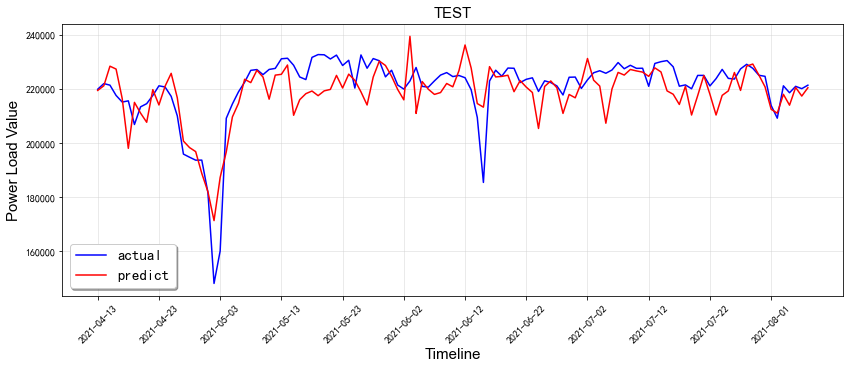

In [77]:
rcParams['figure.figsize'] = 14,5
rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.plot(df_draw_time , y_draw_test,color='b',label='actual')
plt.plot(df_draw_time , y_draw_predict,color='r',label='predict')
plt.xticks(range(0,113,10),rotation=45, fontsize=10)
plt.grid(which='major', color='#cccccc',alpha=0.5)
plt.xlabel('Timeline', family='Arial', fontsize=15)
plt.ylabel('Power Load Value', family='Arial', fontsize=15)
plt.legend(fontsize=15,shadow=True)

plt.title("TEST", family='Arial', fontsize=15)

In [78]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
print('训练集上的MAE/MSE/MAPE')
print(mean_absolute_error(y_draw_predict, y_draw_test))
print(mean_squared_error(y_draw_predict, y_draw_test) )
print(mape(y_draw_predict, y_draw_test) )

训练集上的MAE/MSE/MAPE
6121.074871218488
69517401.33527972
5.120414323150268


Text(0.5, 1.0, 'TEST')

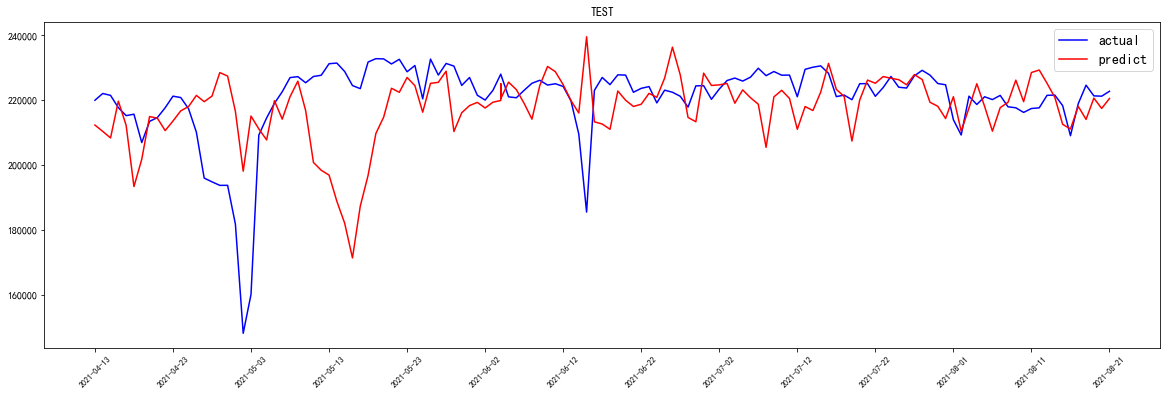

In [67]:
rcParams['figure.figsize'] = 20,6
rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.plot(df_time, y_test,color='b',label='actual')
plt.plot(df_time, pre,color='r',label='predict')
plt.xticks(range(0,133,10),rotation=45, fontsize=8)
plt.legend(fontsize=14)
plt.title("TEST")

In [53]:
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(pre)],axis=1);
draw.columns = ['real','predict']
draw

,real,predict
0,218272.8558,204735.906250
1,198095.4471,207267.093750
2,176500.0678,208498.875000
3,201305.0987,206965.781250
4,213546.5440,210610.093750
...,...,...
128,221476.0038,220383.687500
129,217962.9607,218186.453125
130,217660.4926,219382.718750
131,216230.4143,215881.109375


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

